# Machine Learning on a Public Dataset

Train and Evaluate the machine learning models

## Importing the required libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
# local modules
from src.data_pipeline import BrainDataset
from src.losses import FocalDiceLoss
from src.models import UNet, DeepLabv4
from src.utils import train_one_epoch, evaluate, export2onnx

## Visualizing CossineAnnealing learning rate scheduler

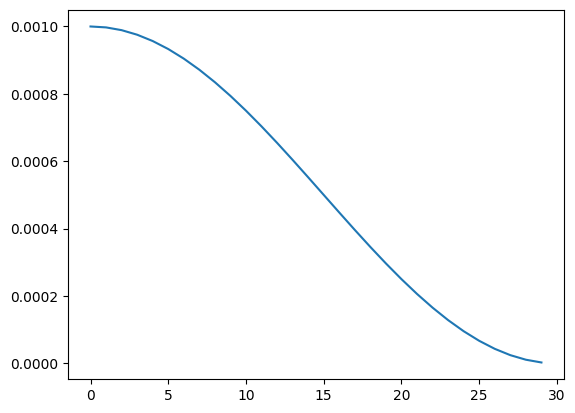

In [2]:
dummy_model = torch.nn.Sequential(torch.nn.Linear(32, 32))
dummy_opt = torch.optim.RAdam(dummy_model.parameters())
dummy_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(dummy_opt, T_max=30)

lrs = []
for ep in range(30):
    lrs.append(dummy_scheduler.get_last_lr())
    dummy_opt.step()
    dummy_scheduler.step()

plt.plot(lrs)
plt.show()

## Building the data pipeline

In [3]:
class RescaleMask:
    def __call__(self, img: torch.Tensor):
        assert img.min() >=0 and img.max() <= 1
        return img.clamp(min=0, max=1)


mask_transform = transforms.Compose([
    transforms.ToTensor(),
    RescaleMask()
])

train_loader = BrainDataset(True, transforms.ToTensor(), mask_transform)
train_loader = DataLoader(train_loader, batch_size=64, shuffle=True)
test_loader = BrainDataset(False, transforms.ToTensor(), mask_transform)
test_loader = DataLoader(test_loader, batch_size=128, shuffle=False)

## Building and Training U-Net

In [4]:
unet_model = DeepLabv4(3, 1)
loss = FocalDiceLoss()
optimizer = torch.optim.RAdam(unet_model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

min_test_loss = 1e10  # keeps the minimum validation loss
writer = SummaryWriter()  # logs evaluation metrics
# train and evaluate
for epoch in range(30):
    print(f'--------- Epoch {epoch + 1} ---------')
    print(f'Current learning rate: {scheduler.get_last_lr()[0]:.5f}')
    # train for one epoch
    train_loss = train_one_epoch(unet_model, loss, optimizer, train_loader)
    writer.add_scalar('Loss/Train', train_loss, epoch)
    # evaluate the model
    (test_loss, test_miou, test_precision, test_sensitivity, test_f1) = evaluate(unet_model, loss, test_loader)
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('mIoU/Test', test_miou, epoch)
    writer.add_scalar('Precision/Test', test_precision, epoch)
    writer.add_scalar('Sensitivity/Test', test_sensitivity, epoch)
    writer.add_scalar("F1 Score/Test", test_f1, epoch)
    # save the best model
    if test_loss < min_test_loss:
        min_test_loss = test_loss
        torch.save(unet_model, 'models/model.pth')
    scheduler.step()

--------- Epoch 1 ---------
Current learning rate: 0.00100


51it [00:45,  1.12it/s]


[Train]  Loss: 1.1009
[Test]  Loss: 1.0162 mIoU: 0.2723 Precision: 0.3658 Recall: 0.7177 F1: 0.3033
--------- Epoch 2 ---------
Current learning rate: 0.00100


51it [00:14,  3.54it/s]


[Train]  Loss: 0.9583
[Test]  Loss: 0.9444 mIoU: 0.7008 Precision: 0.9766 Recall: 0.7186 F1: 0.7212
--------- Epoch 3 ---------
Current learning rate: 0.00099


51it [00:14,  3.54it/s]


[Train]  Loss: 0.8791
[Test]  Loss: 1.1082 mIoU: 0.5219 Precision: 0.6990 Recall: 0.7961 F1: 0.5492
--------- Epoch 4 ---------
Current learning rate: 0.00098


51it [00:14,  3.58it/s]


[Train]  Loss: 0.6853
[Test]  Loss: 0.7742 mIoU: 0.7080 Precision: 0.9602 Recall: 0.7377 F1: 0.7320
--------- Epoch 5 ---------
Current learning rate: 0.00096


51it [00:14,  3.53it/s]


[Train]  Loss: 0.4386
[Test]  Loss: 0.9981 mIoU: 0.6176 Precision: 0.9999 Recall: 0.6176 F1: 0.6193
--------- Epoch 6 ---------
Current learning rate: 0.00093


51it [00:14,  3.60it/s]


[Train]  Loss: 0.2705
[Test]  Loss: 0.5616 mIoU: 0.7375 Precision: 0.9708 Recall: 0.7566 F1: 0.7623
--------- Epoch 7 ---------
Current learning rate: 0.00090


51it [00:14,  3.59it/s]


[Train]  Loss: 0.2583
[Test]  Loss: 0.6565 mIoU: 0.6901 Precision: 0.9464 Recall: 0.7241 F1: 0.7137
--------- Epoch 8 ---------
Current learning rate: 0.00087


51it [00:14,  3.59it/s]


[Train]  Loss: 0.2020
[Test]  Loss: 0.5731 mIoU: 0.7407 Precision: 0.9809 Recall: 0.7542 F1: 0.7625
--------- Epoch 9 ---------
Current learning rate: 0.00083


51it [00:14,  3.56it/s]


[Train]  Loss: 0.1875
[Test]  Loss: 0.6084 mIoU: 0.7172 Precision: 0.9837 Recall: 0.7264 F1: 0.7350
--------- Epoch 10 ---------
Current learning rate: 0.00079


51it [00:14,  3.60it/s]


[Train]  Loss: 0.2012
[Test]  Loss: 0.6031 mIoU: 0.7284 Precision: 0.9769 Recall: 0.7461 F1: 0.7494
--------- Epoch 11 ---------
Current learning rate: 0.00075


51it [00:14,  3.61it/s]


[Train]  Loss: 0.2219
[Test]  Loss: 0.5801 mIoU: 0.7329 Precision: 0.9728 Recall: 0.7543 F1: 0.7529
--------- Epoch 12 ---------
Current learning rate: 0.00070


51it [00:14,  3.56it/s]


[Train]  Loss: 0.1649
[Test]  Loss: 0.5494 mIoU: 0.7478 Precision: 0.9765 Recall: 0.7643 F1: 0.7716
--------- Epoch 13 ---------
Current learning rate: 0.00065


51it [00:14,  3.57it/s]


[Train]  Loss: 0.1598
[Test]  Loss: 0.5257 mIoU: 0.7418 Precision: 0.9553 Recall: 0.7781 F1: 0.7683
--------- Epoch 14 ---------
Current learning rate: 0.00060


51it [00:14,  3.58it/s]


[Train]  Loss: 0.2208
[Test]  Loss: 0.5437 mIoU: 0.7426 Precision: 0.9722 Recall: 0.7637 F1: 0.7660
--------- Epoch 15 ---------
Current learning rate: 0.00055


51it [00:14,  3.61it/s]


[Train]  Loss: 0.1771
[Test]  Loss: 0.5370 mIoU: 0.7487 Precision: 0.9693 Recall: 0.7701 F1: 0.7735
--------- Epoch 16 ---------
Current learning rate: 0.00050


51it [00:14,  3.61it/s]


[Train]  Loss: 0.1457
[Test]  Loss: 0.5098 mIoU: 0.7576 Precision: 0.9722 Recall: 0.7787 F1: 0.7810
--------- Epoch 17 ---------
Current learning rate: 0.00045


51it [00:14,  3.60it/s]


[Train]  Loss: 0.1458
[Test]  Loss: 0.5075 mIoU: 0.7588 Precision: 0.9719 Recall: 0.7795 F1: 0.7818
--------- Epoch 18 ---------
Current learning rate: 0.00040


51it [00:14,  3.55it/s]


[Train]  Loss: 0.1360
[Test]  Loss: 0.4958 mIoU: 0.7626 Precision: 0.9670 Recall: 0.7879 F1: 0.7887
--------- Epoch 19 ---------
Current learning rate: 0.00035


51it [00:14,  3.62it/s]


[Train]  Loss: 0.1528
[Test]  Loss: 0.4717 mIoU: 0.7708 Precision: 0.9673 Recall: 0.7945 F1: 0.7975
--------- Epoch 20 ---------
Current learning rate: 0.00030


51it [00:14,  3.56it/s]


[Train]  Loss: 0.1464
[Test]  Loss: 0.4743 mIoU: 0.7671 Precision: 0.9754 Recall: 0.7830 F1: 0.7946
--------- Epoch 21 ---------
Current learning rate: 0.00025


51it [00:14,  3.53it/s]


[Train]  Loss: 0.1279
[Test]  Loss: 0.4465 mIoU: 0.7764 Precision: 0.9681 Recall: 0.7991 F1: 0.8037
--------- Epoch 22 ---------
Current learning rate: 0.00021


51it [00:14,  3.57it/s]


[Train]  Loss: 0.1274
[Test]  Loss: 0.4120 mIoU: 0.7803 Precision: 0.9694 Recall: 0.8024 F1: 0.8096
--------- Epoch 23 ---------
Current learning rate: 0.00017


51it [00:14,  3.60it/s]


[Train]  Loss: 0.1396
[Test]  Loss: 0.4311 mIoU: 0.7791 Precision: 0.9645 Recall: 0.8057 F1: 0.8067
--------- Epoch 24 ---------
Current learning rate: 0.00013


51it [00:14,  3.52it/s]


[Train]  Loss: 0.1204
[Test]  Loss: 0.4336 mIoU: 0.7785 Precision: 0.9683 Recall: 0.8011 F1: 0.8064
--------- Epoch 25 ---------
Current learning rate: 0.00010


51it [00:13,  3.64it/s]


[Train]  Loss: 0.1156
[Test]  Loss: 0.3939 mIoU: 0.7888 Precision: 0.9619 Recall: 0.8164 F1: 0.8199
--------- Epoch 26 ---------
Current learning rate: 0.00007


51it [00:13,  3.64it/s]


[Train]  Loss: 0.1147
[Test]  Loss: 0.3995 mIoU: 0.7860 Precision: 0.9645 Recall: 0.8119 F1: 0.8163
--------- Epoch 27 ---------
Current learning rate: 0.00004


51it [00:14,  3.56it/s]


[Train]  Loss: 0.1122
[Test]  Loss: 0.4051 mIoU: 0.7843 Precision: 0.9660 Recall: 0.8086 F1: 0.8138
--------- Epoch 28 ---------
Current learning rate: 0.00002


51it [00:14,  3.62it/s]


[Train]  Loss: 0.1128
[Test]  Loss: 0.3981 mIoU: 0.7868 Precision: 0.9647 Recall: 0.8122 F1: 0.8174
--------- Epoch 29 ---------
Current learning rate: 0.00001


51it [00:14,  3.56it/s]


[Train]  Loss: 0.1304
[Test]  Loss: 0.3720 mIoU: 0.7924 Precision: 0.9604 Recall: 0.8211 F1: 0.8241
--------- Epoch 30 ---------
Current learning rate: 0.00000


51it [00:14,  3.58it/s]


[Train]  Loss: 0.1294
[Test]  Loss: 0.3740 mIoU: 0.7924 Precision: 0.9625 Recall: 0.8191 F1: 0.8237


## Visual validation of U-Net

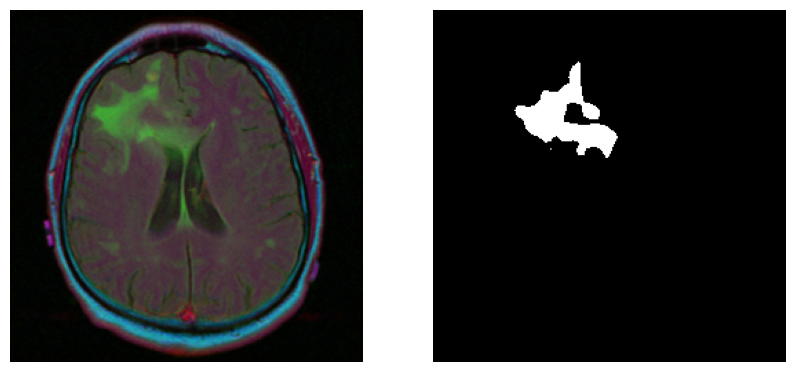

In [5]:
img = cv2.imread('dataset/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif')
transform = transforms.ToTensor()
img = transform(img)
img = img.unsqueeze(0)
assert img.shape == (1, 3, 256, 256)
model = torch.load('models/model.pth')
model.eval()
device = torch.device('cuda')
pred = (model(img.to(device)) > 0.5).float()
assert pred.shape == (1, 1, 256, 256)
pred = pred.squeeze(0)
assert pred.shape == (1, 256, 256)
pred = pred.squeeze()
assert pred.shape == (256, 256)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
pred = pred.detach().cpu().numpy()
assert pred.min() >= 0 and pred.max() <= 1
img = cv2.imread('dataset/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif')
ax1.imshow(img)
ax1.axis('off')
ax2.imshow(pred, cmap='gray')
ax2.axis('off')
plt.show()

# Exporting the trained models to ONNX

In [6]:
export2onnx(
    model=model,
    model_name='models/unet.onnx',
    input_shape=(1, 3, 256, 256)
)